# This notebook has the sole purpose to reproduce the results of the models used.

In [102]:
from ESRGAN.implementations.esrgan.models import GeneratorRRDB
from ESRGAN.implementations.esrgan.datasets import denormalize, mean, std

import torch
from torch.autograd import Variable

# import os
# import numpy as np
# import math
# import cv2
from PIL import Image
from skimage.metrics import structural_similarity

from torchvision import transforms
from torchvision.utils import save_image
from torchmetrics.functional import structural_similarity_index_measure
from torchmetrics import PeakSignalNoiseRatio

%matplotlib inline
import matplotlib.pyplot as plt

## Upload image to test on 

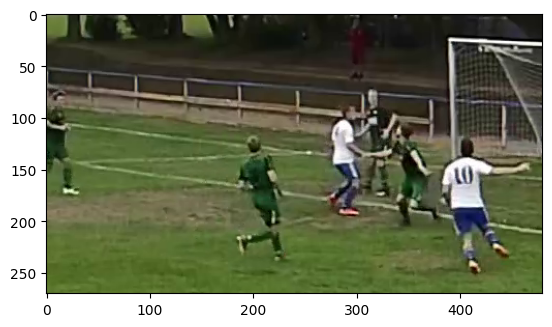

In [103]:
# Change the path to the path of the image you want to upscale
image_path = "94.png"
image = Image.open(image_path)
imgplot = plt.imshow(image)
plt.show()

# Get image parameters
(im_width, im_height) = image.size
im_channels = len(image.getbands())

In [104]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## ESRGAN

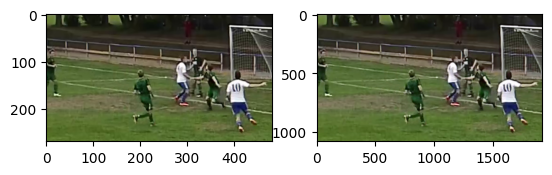

In [107]:
# Define model and load model checkpoint
model_path = "generator_32.pth"
generator = GeneratorRRDB(im_channels, filters=64, num_res_blocks=23, num_upsample=2).to(device)
generator.load_state_dict(torch.load(model_path))
generator.eval()

# Transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

### Prepare input ###
# Just upscale image
image_tensor = Variable(transform(image)).to(device).unsqueeze(0)
# # Downscale and upscale image
# image_tensor = Variable(transform(image.resize((int(im_width/4),int(im_height/4))))).to(device).unsqueeze(0)

# Get SR image
with torch.no_grad():
    sr_image = denormalize(generator(image_tensor)).cpu()

# Save image
save_image(sr_image, "esrgan.png")

# Load image
esrgan_image_path = "esrgan.png"
sr_image = Image.open(esrgan_image_path)

# Plot images next to each other
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[1].imshow(sr_image)

## iSeeBetter